In [78]:
import os
import random
import torch
import numpy as np
import pickle as pkl
from analysis import *
import argparse
from sys import platform
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
torch.manual_seed(12)
torch.cuda.manual_seed(12)
np.random.seed(12)
torch.backends.cudnn.deterministics = True
torch.set_num_threads(1)

In [80]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())


print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
2
0
NVIDIA GeForce RTX 3090


In [81]:
# iv: image option
length = 440
channel = 128
min_CNN = 200
n_classes = 40
classes = range(n_classes)


In [82]:
if platform == "linux" or platform == "linux2":
    torch_models_dir = r"/media/mountHDD1/LanxHuyen/CVPR2017"
elif platform == "win32":
    torch_models_dir = r"D:\Data\CVPR2021-02785\CVPR2021-02785\preprocessed\torch_models"
block_splits_all = '/media/mountHDD1/LanxHuyen/CVPR2017/block_splits_by_image_all.pth' 
eeg_raw = '/media/mountHDD1/LanxHuyen/CVPR2017/eeg_55_95_std.pth'
# block_splits_all, block_splits_single, eeg_14_70, eeg_55_95, eeg_5_95, eeg_raw = os.listdir(torch_models_dir)
# print(os.listdir(torch_models_dir))

In [83]:
# eeg_dataset = os.path.join(torch_models_dir, eeg_5_95)
# splits_all_path = os.path.join(torch_models_dir, block_splits_all)
eeg_dataset = eeg_raw
splits_all_path = block_splits_all
# splits_single_path = os.path.join(torch_models_dir, block_splits_single)
# splits_path = os.path.join(torch_models_dir, splits_shuffled_path)
# print(eeg_dataset,'\n', splits_all_path, '\n', splits_single_path)
print(eeg_dataset,'\n', splits_all_path)

/media/mountHDD1/LanxHuyen/CVPR2017/eeg_55_95_std.pth 
 /media/mountHDD1/LanxHuyen/CVPR2017/block_splits_by_image_all.pth


In [84]:
splits_all = torch.load(splits_all_path)
# splits_single = torch.load(splits_single_path)

In [85]:
print(len(splits_all['splits']))
print(len(splits_all['splits'][0]))

print(len(splits_all['splits'][5]['train']))
print(len(splits_all['splits'][5]['val']))
print(len(splits_all['splits'][5]['test']))
print(splits_all['splits'][0]['train'][:40])
print(splits_all['splits'][1]['train'][:40])
print(splits_all['splits'][2]['train'][:10])
print(splits_all['splits'][3]['train'][:10])


6
3
7984
1996
1985
[0, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 27, 29, 33, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 51, 52, 54, 55]
[1, 2, 3, 4, 6, 8, 9, 12, 13, 20, 25, 26, 27, 28, 30, 32, 33, 35, 37, 38, 39, 40, 44, 45, 46, 50, 52, 54, 56, 58, 59, 60, 62, 65, 68, 72, 73, 74, 76, 81]
[2, 3, 4, 5, 6, 7, 8, 10, 11, 13]
[1, 2, 4, 7, 9, 10, 12, 13, 14, 15]


In [86]:
# # print(splits_single)
# # print(splits_single['splits'])
# print(len(splits_single['splits'][0]['train']))
# print(len(splits_single['splits'][0]['val']))
# print(len(splits_single['splits'][0]['test']))

In [154]:
eeg_loaded = torch.load(eeg_dataset)

In [155]:
print(len(eeg_loaded))
print(eeg_loaded.keys())
dataset, labels, images = [eeg_loaded[k] for k in eeg_loaded.keys()]
print(len(labels))
print(len(images))
print(len(dataset))
# print(len(means))
# print(len(stddevs))
# print(means)
# print(stddevs)
print(*labels)
print(images[0])
print(dataset[0]['eeg'].shape)
print(dataset[9969])
#Trial 0-1995 - subject 4
#Trial 1996 - 3980 - subject 1
#Trial 3981 - 5976 - subject 6
#Trial 5977 - 7972 - subject 3
#Trial 7973 - 9968 - subject 2
#Trial 9969 - 11964 - subject 5

3
dict_keys(['dataset', 'labels', 'images'])
40
1996
11965
n02389026 n03888257 n03584829 n02607072 n03297495 n03063599 n03792782 n04086273 n02510455 n11939491 n02951358 n02281787 n02106662 n04120489 n03590841 n02992529 n03445777 n03180011 n02906734 n07873807 n03773504 n02492035 n03982430 n03709823 n03100240 n03376595 n03877472 n03775071 n03272010 n04069434 n03452741 n03792972 n07753592 n13054560 n03197337 n02504458 n02690373 n03272562 n04044716 n02124075
n02951358_31190
torch.Size([128, 500])
{'eeg': tensor([[ 4.3154e-02,  4.7046e-01,  8.1451e-01,  ...,  1.6328e+00,
          8.9757e-01, -7.6260e-03],
        [ 1.4745e-01,  1.9753e+00,  3.4403e+00,  ...,  5.4654e+00,
          2.9874e+00, -4.0782e-02],
        [-6.0167e-02, -9.1679e-01, -1.6048e+00,  ..., -2.1591e+00,
         -1.1712e+00,  2.4655e-02],
        ...,
        [-1.3750e-01,  8.1950e-01,  1.6004e+00,  ..., -1.4219e+00,
         -7.1263e-01,  1.4110e-01],
        [-5.2204e-03,  3.1537e-02,  6.1560e-02,  ..., -6.2863e-02,
  

In [161]:
import numpy as np
eeg_length = np.zeros(len(dataset))
for i in range(len(dataset)):
    eeg_length[i] = list(dataset[i]['eeg'].size())[1]

In [162]:
sub_length = np.empty(len(dataset))
for i in range(len(dataset)):
    sub_length[i] = dataset[i]['subject']

In [163]:
# print(dataset['eeg'].size())
import torch.nn.functional as F
desired_size = 500

new_dataset = torch.zeros(len(dataset), 128, desired_size)

for i in range(len(dataset)):
    eeg_data = dataset[i]['eeg']

    # Convert the tensor to torch.float32
    eeg_data_float = eeg_data.to(torch.float32)

    # Resize using linear interpolation
    resized_eeg = F.interpolate(eeg_data_float.unsqueeze(0), size=desired_size, mode='linear')

    # Convert the resized tensor back to the original data type (if needed)
    resized_eeg = resized_eeg.to(eeg_data.dtype)

    new_dataset[i, :, :] = resized_eeg.squeeze(0)

In [167]:
new_dataset.size()


torch.Size([11965, 128, 500])

In [193]:
filtered_dataset = torch.empty(6, 128, 500)
empty_dataset = torch.empty(128,500)

In [205]:
for i in range(len(new_dataset)):
    for j in range(2000):
        filtered_dataset_4 = torch.cat([empty_dataset, new_dataset[i]])
        filtered_dataset_1 = torch.cat([empty_dataset, new_dataset[i+2000]])
        filtered_dataset_6 = torch.cat([empty_dataset, new_dataset[i+4000]])
        filtered_dataset_3 = torch.cat([empty_dataset, new_dataset[i+6000]])
        filtered_dataset_2 = torch.cat([empty_dataset, new_dataset[i+8000]])
        filtered_dataset_5 = torch.cat([empty_dataset, new_dataset[i+10000]])
    filtered_dataset = torch.cat([filtered_dataset_4, filtered_dataset_1, filtered_dataset_6, filtered_dataset_3, filtered_dataset_2, filtered_dataset_5])

IndexError: index 11965 is out of bounds for dimension 0 with size 11965

In [170]:
# for i in range(len(new_dataset)):
#     image_index = dataset[i]['image']
#     subject_index = dataset[i]['subject']
#     filtered_dataset[subject_index-1, :, :] = new_dataset[image_index]

In [160]:
print(filtered_dataset)

tensor([[[-3.9569e-02,  9.0167e-02,  2.0777e-01,  ...,  1.7606e-02,
          -6.3196e-03, -2.7017e-02],
         [-3.2104e-02,  2.5068e-02,  9.0770e-02,  ...,  3.3496e-01,
           1.7660e-01, -2.4202e-02],
         [ 1.0576e-02, -3.8747e-01, -6.8491e-01,  ..., -9.7595e-01,
          -5.4670e-01,  1.7024e-02],
         ...,
         [-4.3268e-03, -4.7298e-01, -8.1574e-01,  ...,  3.5673e-01,
           1.9036e-01, -9.0540e-03],
         [-1.1820e-04, -1.9891e-02, -3.4024e-02,  ...,  1.2457e-02,
           6.3596e-03, -3.7886e-04],
         [-4.4167e-03, -1.3268e-01, -2.2384e-01,  ...,  4.9450e-02,
           2.0687e-02, -6.3570e-03]],

        [[-3.9569e-02,  9.0167e-02,  2.0777e-01,  ...,  1.7606e-02,
          -6.3196e-03, -2.7017e-02],
         [-3.2104e-02,  2.5068e-02,  9.0770e-02,  ...,  3.3496e-01,
           1.7660e-01, -2.4202e-02],
         [ 1.0576e-02, -3.8747e-01, -6.8491e-01,  ..., -9.7595e-01,
          -5.4670e-01,  1.7024e-02],
         ...,
         [-4.3268e-03, -4

In [15]:
# for i in range(len(dataset)):
#     # Normalize each component using mean and stddev
#    new_dataset[i, :, :] = (new_dataset[i, :, :] - means) / stddevs

In [117]:
# print(new_dataset.size())
# print(new_dataset[0])

# import matplotlib.pyplot as plt
# plt.plot(new_dataset[0][0])

In [131]:
heatmap_image = filtered_dataset

In [132]:
heatmap_image.size()

torch.Size([6, 128, 500])

In [33]:
# Normalize the heatmap image to [0, 255]
heatmap_image_normalized = ((heatmap_image - heatmap_image.min()) /
                            (heatmap_image.max() - heatmap_image.min()) * 255).byte()

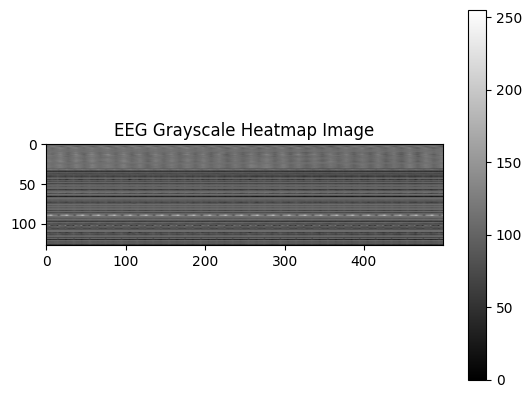

In [34]:
# Convert the tensor to a NumPy array for plotting
heatmap_image_np = heatmap_image_normalized.numpy()

# Display the heatmap image
plt.imshow(heatmap_image_np, cmap='gray')
plt.title("EEG Grayscale Heatmap Image")
plt.colorbar()
plt.show()

In [36]:
print(heatmap_image_np)
print(heatmap_image_np.shape)

[[111 111 112 ...  98  97  97]
 [107 108 108 ... 103 102 101]
 [120 119 117 ... 106 108 109]
 ...
 [ 63  64  63 ...  60  59  56]
 [109 109 109 ... 108 108 108]
 [ 48  48  48 ...  46  45  45]]
(128, 500)


In [96]:
for i in range(len(dataset)):
    dataset[i]['eeg'] = new_dataset[i]

In [97]:
print(dataset[2])

{'eeg': tensor([[-0.4418, -0.4065, -0.3536,  ..., -0.2831, -0.2831, -0.3007],
        [-0.3063, -0.2911, -0.2452,  ..., -0.1841, -0.1535, -0.1535],
        [ 0.0021,  0.0021, -0.0243,  ..., -0.5258, -0.5390, -0.5126],
        ...,
        [-0.1878, -0.2213, -0.2407,  ..., -0.3077, -0.2953, -0.2618],
        [ 0.0057,  0.0032,  0.0024,  ...,  0.0070,  0.0066,  0.0042],
        [-0.0984, -0.1200, -0.1327,  ..., -0.0573, -0.0563, -0.0642]]), 'image': 2, 'label': 29, 'subject': 4}


In [98]:
opt = {
    # Dataset options
#     "iv": "image",
#     "offset": None,
    "results_file": "results.pkl",
    "subject": 0,
    "time_low": 20,
    "time_high": 460,
#     "run": "none",
    "eeg_dataset": eeg_dataset,
    "model_type": "model10",
    "splits_path": splits_all_path,
    "split_num": 0,
    "split_name": "train",
#     "fold": 5,
    #Training options
    "batch_size": 16,
    "optim": "Adam",
    "learning_rate": 0.001,
    "learning_rate_decay_by": 0.5,
    "learning_rate_decay_every": 10,
    "epochs": 100,
    "GPUindex": 0,
    "kind":"from-scratch",
    #Backend options
    "no_cuda": False,
    "classifier": None
}
opt = argparse.Namespace(**opt)
print(opt)

Namespace(results_file='results.pkl', subject=0, time_low=20, time_high=460, eeg_dataset='/media/mountHDD1/LanxHuyen/CVPR2017/eeg_raw.pth', model_type='model10', splits_path='/media/mountHDD1/LanxHuyen/CVPR2017/block_splits_by_image_all.pth', split_num=0, split_name='train', batch_size=16, optim='Adam', learning_rate=0.001, learning_rate_decay_by=0.5, learning_rate_decay_every=10, epochs=100, GPUindex=0, kind='from-scratch', no_cuda=False, classifier=None)


In [99]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
# from data_loader import EEGDataset, Splitter, SplitterWithData
from data_loader_CVPR2017 import EEGDataset, Splitter
from EEG_Encoder.LSTM import classifier_LSTM
from EEG_Encoder.CNN import classifier_CNN
from EEG_Encoder.EEGNet import classifier_EEGNet
from EEG_Encoder.SyncNet import classifier_SyncNet
from EEG_Encoder.EEGChannelNet import classifier_EEGChannelNet
from EEG_Encoder.net_generator import Classifier
from EEG_Encoder.net_trainer import net_trainer
from p_values import *
from torchinfo import summary

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
def load_dataset(
#              offset,
             eeg_dataset,
             splits_path,
             split_num, # (0-5) - 6 fold cross validation
#              total, 
#              classes,
#              classifier,
             batch_size,
#              GPUindex,
#              length, # 500
#              channel, # 128
#              min_CNN,
             opt,
             kind="from-scratch"):        
    # Load dataset
    dataset = EEGDataset(opt, eeg_dataset)
    print("DONE: LOAD DATASET")
#     # Create loaders for LSTM/MLP/CNN/SCNN/EEGNet/SyncNet/EEGChannelNet
#     if kind=="from-scratch":
#         relabel = False
#     if kind=="incremental":
#         relabel = False
#     if kind=="no-model-file":
#         relabel = True
    splitter = {split: Splitter(dataset,
                    splits_path,
                    split_num,
                    split_name=split) for split in ["train", "val", "test"]}
    loaders = {split: DataLoader(
                        splitter[split],
                        batch_size = batch_size,
                        drop_last = False,
                        shuffle = True)
                    for split in ["train", "val", "test"]}
    channel_idx = None    
    print("DONE: Create loaders for model")            
    return dataset, loaders, splitter

In [101]:
# Options
opt.classifier = "LSTM4"
opt.batch_size = 16
# opt.kind = "from-scratch"
# opt.run = "imagenet40-1000"
# opt.fold = 5

In [102]:
dataset, loaders, splitter = load_dataset(
#              offset,
             opt.eeg_dataset,
             opt.splits_path,
             opt.split_num, # (0-5) - 6 fold cross validation
#              total, 
#              classes,
#              classifier,
             opt.batch_size,
#              GPUindex,
#              length, # 500
#              channel, # 128
#              min_CNN,
             opt,
             opt.kind)

DONE: LOAD DATASET
DONE: Create loaders for model


In [103]:
# loaders: divide the splits data in each fold with batch_size
# Each fold has {train: 8000 idx, val: 2000 idx, test: 2000 idx}
# Each loader batch has {train: 2000 idx, val: 250 idx, test: 250 idx}
print(type(dataset))
print(type(loaders))
print(len(loaders), [len(loaders[name]) for name in ["train", "val", "test"] ])
# for i, (input, target) in enumerate(loaders["train"]):
#     if i<20:
#         print(f"{i+1}: Target size: {target.size()}; input size: {input.size()}")
for i in range(0, 40):
    eeg, label_val = splitter["val"][i]
    eeg, label_train = splitter["train"][i]
    print(f"{i+1}: Label val: {label_val}; label train: {label_train}")


<class 'data_loader_CVPR2017.EEGDataset'>
<class 'dict'>
3 [498, 125, 125]
1: Label val: 37; label train: 10
2: Label val: 38; label train: 10
3: Label val: 11; label train: 30
4: Label val: 10; label train: 25
5: Label val: 7; label train: 18
6: Label val: 35; label train: 3
7: Label val: 13; label train: 8
8: Label val: 2; label train: 11
9: Label val: 14; label train: 18
10: Label val: 2; label train: 28
11: Label val: 33; label train: 38
12: Label val: 26; label train: 20
13: Label val: 34; label train: 3
14: Label val: 18; label train: 28
15: Label val: 11; label train: 23
16: Label val: 32; label train: 0
17: Label val: 6; label train: 34
18: Label val: 22; label train: 20
19: Label val: 24; label train: 23
20: Label val: 24; label train: 39
21: Label val: 29; label train: 0
22: Label val: 3; label train: 34
23: Label val: 25; label train: 21
24: Label val: 11; label train: 39
25: Label val: 22; label train: 6
26: Label val: 36; label train: 26
27: Label val: 30; label train: 20


In [104]:
net, nonclasses = Classifier(
                 n_classes,
                 classes,
                 opt.classifier,
                 opt.GPUindex,
                 length,
                 channel,
                 min_CNN,
                 opt.kind)
# print(len(nonclasses))
summary(net, input_size=(1,128, 440))

DONE: CREATE TORCH CLASSIFIER
classifier_LSTM(
  (lstm): LSTM(128, 128, batch_first=True)
  (output1): Linear(in_features=128, out_features=128, bias=True)
  (relu): ReLU()
  (output2): Linear(in_features=128, out_features=40, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
classifier_LSTM                          [1, 40]                   --
├─LSTM: 1-1                              [1, 440, 128]             132,096
├─Linear: 1-2                            [1, 128]                  16,512
├─ReLU: 1-3                              [1, 128]                  --
├─Linear: 1-4                            [1, 40]                   5,160
Total params: 153,768
Trainable params: 153,768
Non-trainable params: 0
Total mult-adds (M): 58.14
Input size (MB): 0.23
Forward/backward pass size (MB): 0.45
Params size (MB): 0.62
Estimated Total Size (MB): 1.29

In [105]:
model_path = (   "CVPR2017-" +
                  opt.classifier+
                  "-"+
                  str(length)+
                  "-"+
                  str(channel)+
                  "-"+
                  'Retest' )
print(model_path)

CVPR2017-LSTM4-440-128-Retest


In [106]:
print(opt)

Namespace(results_file='results.pkl', subject=0, time_low=20, time_high=460, eeg_dataset='/media/mountHDD1/LanxHuyen/CVPR2017/eeg_raw.pth', model_type='model10', splits_path='/media/mountHDD1/LanxHuyen/CVPR2017/block_splits_by_image_all.pth', split_num=0, split_name='train', batch_size=16, optim='Adam', learning_rate=0.001, learning_rate_decay_by=0.5, learning_rate_decay_every=10, epochs=100, GPUindex=0, kind='from-scratch', no_cuda=False, classifier='LSTM4')


In [107]:
channel_idx=None
non_classes=None
if opt.kind=="from-scratch":
    results = net_trainer(
            net,
            loaders,
            opt,
            channel_idx,
            nonclasses,
            None,
            True,
            model_path,
            print_every_train = 100,
            print_every_val = 125)

Epoch 1
Train Batch 100 (every 100 batch): Loss=3.6709; accuracy=0.0369
Train Batch 200 (every 100 batch): Loss=3.5423; accuracy=0.0444
Train Batch 300 (every 100 batch): Loss=3.6650; accuracy=0.0531
Train Batch 400 (every 100 batch): Loss=3.4594; accuracy=0.0564
Epoch 1 summary: train_loss: 3.6030 | train_acc: 0.0562 | val_loss: 3.4790 | val_acc: 0.0835
Epoch 2
Train Batch 100 (every 100 batch): Loss=3.3980; accuracy=0.0844
Train Batch 200 (every 100 batch): Loss=3.2605; accuracy=0.0884
Train Batch 300 (every 100 batch): Loss=3.6356; accuracy=0.0919
Train Batch 400 (every 100 batch): Loss=3.2727; accuracy=0.0953
Epoch 2 summary: train_loss: 3.3817 | train_acc: 0.0981 | val_loss: 3.3471 | val_acc: 0.0970
Epoch 3
Train Batch 100 (every 100 batch): Loss=3.1650; accuracy=0.1294
Train Batch 200 (every 100 batch): Loss=2.9315; accuracy=0.1216
Train Batch 300 (every 100 batch): Loss=3.3707; accuracy=0.1185
Train Batch 400 (every 100 batch): Loss=3.4286; accuracy=0.1222
Epoch 3 summary: train

Train Batch 100 (every 100 batch): Loss=0.1550; accuracy=0.9006
Train Batch 200 (every 100 batch): Loss=0.3906; accuracy=0.9047
Train Batch 300 (every 100 batch): Loss=0.3261; accuracy=0.9083
Train Batch 400 (every 100 batch): Loss=0.6428; accuracy=0.9066
Epoch 47 summary: train_loss: 0.3177 | train_acc: 0.9004 | val_loss: 4.7394 | val_acc: 0.2010
Epoch 48
Train Batch 100 (every 100 batch): Loss=0.1733; accuracy=0.9169
Train Batch 200 (every 100 batch): Loss=0.3384; accuracy=0.9178
Train Batch 300 (every 100 batch): Loss=0.1867; accuracy=0.9167
Train Batch 400 (every 100 batch): Loss=0.6507; accuracy=0.9172
Epoch 48 summary: train_loss: 0.2767 | train_acc: 0.9110 | val_loss: 4.8376 | val_acc: 0.2001
Epoch 49
Train Batch 100 (every 100 batch): Loss=0.4388; accuracy=0.9013
Train Batch 200 (every 100 batch): Loss=0.1834; accuracy=0.8944
Train Batch 300 (every 100 batch): Loss=0.8391; accuracy=0.8906
Train Batch 400 (every 100 batch): Loss=0.2250; accuracy=0.8869
Epoch 49 summary: train_lo

Train Batch 100 (every 100 batch): Loss=0.4704; accuracy=0.8187
Train Batch 200 (every 100 batch): Loss=0.2372; accuracy=0.8181
Train Batch 300 (every 100 batch): Loss=0.2904; accuracy=0.8152
Train Batch 400 (every 100 batch): Loss=0.2112; accuracy=0.8194
Epoch 70 summary: train_loss: 0.5636 | train_acc: 0.8289 | val_loss: 5.8814 | val_acc: 0.2016
Epoch 71
Train Batch 100 (every 100 batch): Loss=0.3092; accuracy=0.9256
Train Batch 200 (every 100 batch): Loss=0.3137; accuracy=0.9300
Train Batch 300 (every 100 batch): Loss=0.0731; accuracy=0.9383
Train Batch 400 (every 100 batch): Loss=0.2065; accuracy=0.9442
Epoch 71 summary: train_loss: 0.1714 | train_acc: 0.9450 | val_loss: 5.7815 | val_acc: 0.2046
Epoch 72
Train Batch 100 (every 100 batch): Loss=0.0299; accuracy=0.9656
Train Batch 200 (every 100 batch): Loss=0.0485; accuracy=0.9716
Train Batch 300 (every 100 batch): Loss=0.0297; accuracy=0.9727
Train Batch 400 (every 100 batch): Loss=0.0633; accuracy=0.9722
Epoch 72 summary: train_lo

Train Batch 100 (every 100 batch): Loss=0.0293; accuracy=0.9712
Train Batch 200 (every 100 batch): Loss=0.0162; accuracy=0.9678
Train Batch 300 (every 100 batch): Loss=0.1756; accuracy=0.9677
Train Batch 400 (every 100 batch): Loss=0.0787; accuracy=0.9627
Epoch 93 summary: train_loss: 0.1430 | train_acc: 0.9585 | val_loss: 6.7716 | val_acc: 0.2149
Epoch 94
Train Batch 100 (every 100 batch): Loss=0.0577; accuracy=0.9700
Train Batch 200 (every 100 batch): Loss=0.1885; accuracy=0.9656
Train Batch 300 (every 100 batch): Loss=0.1342; accuracy=0.9652
Train Batch 400 (every 100 batch): Loss=0.3027; accuracy=0.9586
Epoch 94 summary: train_loss: 0.1505 | train_acc: 0.9534 | val_loss: 7.1981 | val_acc: 0.1959
Epoch 95
Train Batch 100 (every 100 batch): Loss=0.1803; accuracy=0.9500
Train Batch 200 (every 100 batch): Loss=0.0802; accuracy=0.9528
Train Batch 300 (every 100 batch): Loss=0.0852; accuracy=0.9508
Train Batch 400 (every 100 batch): Loss=0.0628; accuracy=0.9506
Epoch 95 summary: train_lo

In [ ]:
# val = results["val_acc"]
# # test = results["test_acc"]

# print("Validation accuracy: ", val)
# # print("Test accuracy: ", test)

In [ ]:
print(accuracy_val)